In [36]:
import pandas as pd
import numpy as np
import functions as f
from sklearn import linear_model

import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_style('darkgrid')

# make sure that in your repo, there is a symlink (named 'data') to the real 'data' folder
def data_loc(filename):
    import os
    return os.path.join(os.readlink('data'), filename)

# if you make changes to functions.py, use this before running anything:
reload(f)

<module 'functions' from 'functions.pyc'>

# Import and preprocess court data

In [37]:
# choose cols to import. goes very slowly if you try to import everything, and some cols make it error. see file
# import_cols = ['attend', 'racdin', 'racmar', 'year']

# chunksize must be None or >= 57061 rows (for GSS), because of pandas flaw
aff_ac = f.load_dta(data_loc('Circuit Cases/affirmative_action_panel_level.dta'), chunksize = None)
race_discr = f.load_dta(data_loc('Circuit Cases/race_discrimination_panel_level.dta'), chunksize = None)

aff_ac['casetype'] = "aff_ac"
race_discr['casetype'] = "race_discr"

# join the two datasets, convert the date
joint = pd.concat([aff_ac, race_discr]) 
joint['date'] = pd.to_datetime(joint.year.astype(int)*10000 + joint.month.astype(int)*100 + np.random.randint(1, 29, size = len(joint)), format='%Y%m%d')

Loaded 153 rows...
Done!
Loaded 308 rows...
Done!


In [38]:
joint = joint[["circuit", "year", "panelvote", "casetype"]]
joint.year = joint.year.astype(int)

In [39]:
joint['votelib'] = joint['panelvote']
joint['votecons'] = 3 - joint['panelvote']
joint['votenorm'] = 1.5 - joint['panelvote']

In [40]:
joint.year.describe()

count     461.000000
mean     1996.876356
std         5.784904
min      1980.000000
25%      1995.000000
50%      1998.000000
75%      2001.000000
max      2004.000000
Name: year, dtype: float64

In [41]:
groupby_type = joint.groupby('casetype')

In [42]:
groupby_type.year.describe()

casetype         
aff_ac      count     153.000000
            mean     1991.751634
            std         6.958789
            min      1980.000000
            25%      1986.000000
            50%      1992.000000
            75%      1998.000000
            max      2003.000000
race_discr  count     308.000000
            mean     1999.422078
            std         2.564560
            min      1995.000000
            25%      1997.000000
            50%      2000.000000
            75%      2001.000000
            max      2004.000000
dtype: float64

In [43]:
groupby_year_type = joint.groupby(['casetype', 'year'])
groupby_year_type = groupby_year_type.votenorm.aggregate(np.sum).reset_index()
# lets just take affirmative action cases for now
affirm_year = groupby_year_type[groupby_year_type['casetype']=='aff_ac'].set_index('year')


In [44]:
years = []
lags = []
casesums = []
for y in range(1985, 2005):
    for l in range(1, 6):
        years.append(y)
        lags.append(l)
        casesums.append(affirm_year.at[y-l, 'votenorm'])

In [45]:
affirm_5yr = pd.DataFrame({'year': years, 'lag': lags, 'casesum': casesums})

In [46]:
affirm_5yr = affirm_5yr.set_index(['year', 'lag'])

# Import and preprocess GSS data

In [82]:
# choose cols to import. goes very slowly if you try to import everything, and some cols make it error. see file
import_cols = ['affrmact', 'year', 'age', 'sex', 'race', 'region', 'educ', 'relig']
# import_cols = ['racdin', 'year', 'age', 'sex']
# these seem like all of the relevant categories. Some of them don't plot nicely yet.



# chunksize must be None or >= 57061 rows (for GSS), because of pandas flaw
gss = f.load_dta(data_loc('GSS7212_R2.DTA'), chunksize = None,
                 columns = import_cols)



Loaded 57061 rows...
Done!


In [83]:
# what the df looks like before modification
gss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57061 entries, 0 to 57060
Data columns (total 8 columns):
affrmact    14128 non-null category
year        57061 non-null int16
age         56859 non-null category
sex         57061 non-null category
race        57061 non-null category
region      57061 non-null category
educ        56897 non-null category
relig       56828 non-null category
dtypes: category(7), int16(1)
memory usage: 948.3 KB


In [84]:
gss.affrmact.unique()

[NaN, strongly support pref, strongly oppose pref, support pref, oppose pref]
Categories (4, object): [strongly support pref < support pref < oppose pref < strongly oppose pref]

In [85]:
gss.year.describe()

count    57061.000000
mean      1992.084261
std         11.724820
min       1972.000000
25%       1983.000000
50%       1993.000000
75%       2002.000000
max       2012.000000
Name: year, dtype: float64

In [86]:
# drop all rows where y variable is NA
gss = gss[gss['affrmact'].notnull()]

In [87]:

# change age to number (89+ just coded as 89)
gss.age = gss.age.cat.codes + 18
age_mean = gss.age.mean()
gss.age = gss.age.fillna(age_mean)

In [88]:
# map sex to numeric
gss.sex = gss.sex.map({'female': 0, 'male': 1}).astype(int)

In [89]:
# change racdin to numeric
gss.affrmact = gss.affrmact.map({'strongly support pref': 1.5, 'support pref': .5, 'oppose pref': -.5, 'strongly oppose pref': -1.5})

In [90]:
# fill in missing educ values with mean
gss.educ = gss.educ.cat.codes
educ_mean = gss.educ.mean()
gss.educ = gss.educ.replace(-1, educ_mean)


In [91]:
gss = gss[(gss['year'] > 1984) & (gss['year'] < 2005)]

In [92]:
gss = gss.reset_index()

In [93]:
for l in range(1, 6):
    gss['courtlag' + str(l)] = 0
for i in range(len(gss)):
    curr_year = gss.loc[i, 'year']
    for l in range(1, 6):
        gss.loc[i, 'courtlag' + str(l)] = affirm_5yr.loc[(curr_year, l), 'casesum'] 
    

In [94]:
gss['year'] = gss.year - gss.year.mean()

In [95]:
# change categorical variables to one-hot encoding
gss = pd.concat([gss, pd.get_dummies(gss['race'], prefix='race')], axis=1)
gss = pd.concat([gss, pd.get_dummies(gss['region'], prefix='region')], axis=1)
gss = pd.concat([gss, pd.get_dummies(gss['relig'], prefix='relig')], axis=1)

In [96]:
gss = gss.drop(['race', 'region', 'relig'], axis=1)

In [97]:
# add interactions with time
columns = gss.columns.tolist()
for c in columns[2:]:
    gss[c + '_X_year'] = gss[c] * gss['year']

In [98]:
gss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8398 entries, 0 to 8397
Data columns (total 70 columns):
index                                   8398 non-null int64
affrmact                                8398 non-null float64
year                                    8398 non-null float64
age                                     8398 non-null int8
sex                                     8398 non-null int64
educ                                    8398 non-null float64
courtlag1                               8398 non-null float64
courtlag2                               8398 non-null float64
courtlag3                               8398 non-null float64
courtlag4                               8398 non-null float64
courtlag5                               8398 non-null float64
race_white                              8398 non-null float64
race_black                              8398 non-null float64
race_other                              8398 non-null float64
region_new england              

In [100]:
# randomly split out 2000 test examples
gss = gss.iloc[np.random.permutation(len(gss))]
traindata = gss.values[0:(len(gss)-2000), 0:]
testdata = gss.values[(len(gss)-2000):, 0:]
print traindata.shape
print testdata.shape

(6398, 70)
(2000, 70)


In [109]:
regmodel = linear_model.Ridge()
regmodel.fit(traindata[0:, 2:], traindata[0:, 1])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [110]:
print regmodel.score(traindata[0:, 2:], traindata[0:, 1])
print regmodel.score(testdata[0:, 2:], testdata[0:, 1])

0.121319353692
0.155748184637


In [113]:
results = pd.DataFrame({'param': gss.columns.tolist()[2:],
                        'value': regmodel.coef_})

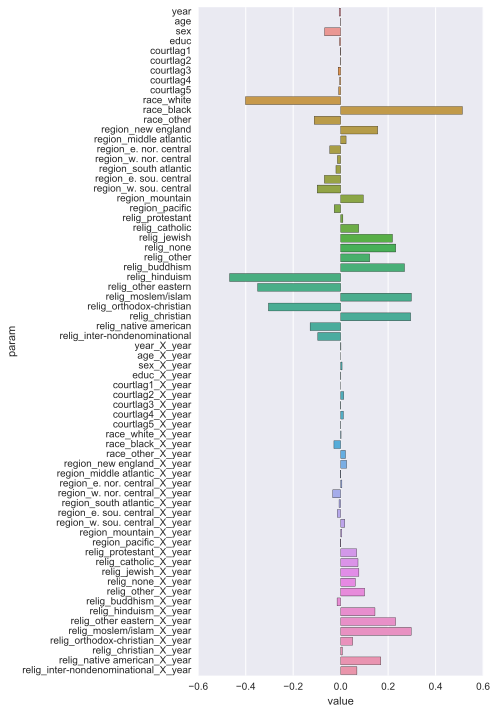

In [114]:
sns.factorplot('value', 'param', kind="bar", data=results, size=10, aspect=.7)

In [54]:
gss.year.describe()

count    12033.000000
mean      1978.050195
std          4.378776
min       1972.000000
25%       1974.000000
50%       1977.000000
75%       1982.000000
max       1985.000000
Name: year, dtype: float64